In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from numpy import ma
from matplotlib import ticker, cm
import time

def FEM(Nx, Ny, E1, nu1, E2, nu2, py, xl, xr):
    f = 0,0
    s = 1,1
    h = s[0]/10
    x_nodes = [i%Nx/(Nx-1)*(s[0] - f[0]) for i in range(Nx*Ny)]
    y_nodes = [i//Ny/(Ny-1)*(s[0] - f[0]) for i in range(Nx*Ny)]
    elements = []
    for j in range(Ny-1):
        for i in range(Nx-1):
            elements.append(i+j*Nx)
            elements.append(i+j*Nx+1)
            elements.append(i+Nx+j*Ny)
        for i in range(Nx-1):
            elements.append(i+j*Nx+1)
            elements.append(i+1+Nx+j*Nx)
            elements.append(i+Nx+j*Nx)

    elements = np.asarray(elements)
    elements = elements.reshape(-1,3)
    S = (s[0] - f[0]) / (Nx - 1) * (s[1] - f[1]) / (Ny - 1) * 0.5

    D = E1/(1-nu1**2)*np.asarray([[1, nu1, 0], 
                    [nu1, 1, 0], 
                    [0, 0, (1-nu1)/2]])

    D1 = E2/(1-nu2**2)*np.asarray([[1, nu2, 0], 
                    [nu2, 1, 0], 
                    [0, 0, (1-nu2)/2]])

    B_arr = []

    K = np.zeros((Nx*Ny*2, Nx*Ny*2))
    for inc, el in enumerate(elements):
        b = [y_nodes[el[(1+i)%3]] - y_nodes[el[(2+i)%3]] for i in range(3)]
        c = [x_nodes[el[(2+i)%3]] - x_nodes[el[(1+i)%3]] for i in range(3)]
        B = np.asarray([[b[0], 0, b[1], 0 ,b[2], 0],
             [0, c[0], 0, c[1], 0, c[2]],
             [c[0], b[0], c[1], b[1], c[2], b[2]]])/(2*S)
        B_arr.append(B)

        if(inc<len(elements)//2):
            k = B.T@D1@B*S*h
        else:
            k = B.T@D@B*S*h
        lv = np.asarray([1,0,1,0,1,0])
        rv = np.asarray([0,1,0,1,0,1]).T
        for i in range(3):
            for j in range(3):
                K[el[i]*2:el[i]*2+2,el[j]*2:el[j]*2+2] += k[i*2:i*2+2, j*2:j*2+2]

    def grad_solve(A, b, x0, mask):
        x = x0
        r = b - A@x
        r[mask] = 0
        p = r
        r_norm = np.sum(r*r)
        b_norm = np.sum(b*b)
        inc = 0
        while (not(r_norm < np.sum(b*b)*1e-9) or k<20):
            if(r_norm < b_norm*1e-9):
                k+=1
            else:
                k=0
            r_norm = np.sum(r*r)
            Ap = (A@p)
            Ap[mask] = 0
            a = r_norm/np.sum(Ap*p)
            x_n = x + a*p
            r_n = r - a*(Ap)
            x_n[mask] = 0
            r_n[mask] = 0
            bt = np.sum(r_n*r_n)/r_norm
            p_n = r_n + bt*p
            p_n[mask] = 0
            x, r, p = x_n, r_n, p_n
            b_norm = np.sum(b*b)
        return x

    f = np.zeros(Nx*Ny*2)
    f_node = Nx*Ny - Nx + xl
    l_node = Nx*Ny - 1 - xr
    nodes_f = []
    for i in range(f_node, l_node):
        nodes_f.append((i, i+1)) 
    for n in nodes_f:
        f[n[0]*2+1]+=1/2*py/(len(nodes_f))*h
        f[n[1]*2+1]+=1/2*py/(len(nodes_f))*h
    x0 = np.random.sample(Nx*Ny*2) + 1e-6
    for i in range(len(x0)):
        if(i<(Nx*2) or i%(Nx*2)==(Nx*2)-2 or i%(Nx*2)==0):
            x0[i] = 0
    mask = np.where(x0==0)

    u = grad_solve(K, f, x0, mask)
    uy = np.zeros(Nx*Ny)
    ux = np.zeros(Nx*Ny)

    for i in range(Nx*Ny*2):
        if(i%2):
            uy[(i-1)//2] = u[i]
        else:
            ux[i//2] = u[i]

    ex = []
    ey = []
    exy = []
    sigx = []
    sigy = []
    sigxy = []
    pointsx = []
    pointsy = []
    for i, el in enumerate(elements):
        mask = []
        for n in el:
            mask.append(2*n) 
            mask.append(2*n+1)
        e = B_arr[i]@u[mask]
        if(i<len(elements)//2):
            sig = D1@e.T
        else:
            sig = D@e.T
        sigx.append(sig[0])
        sigy.append(sig[1])
        sigxy.append(sig[2])
        ex.append(e[0])
        ey.append(e[1])
        exy.append(e[2])
        pointx = 0
        pointy = 0
        if(y_nodes[el[0]] == y_nodes[el[1]]):
            pointx = x_nodes[el[0]] + (x_nodes[el[1]] - x_nodes[el[0]])/2
            pointy = y_nodes[el[0]] + (y_nodes[el[2]] - y_nodes[el[0]])/4 
        else:
            pointx = x_nodes[el[0]] + (x_nodes[el[1]] - x_nodes[el[0]])/2
            pointy = y_nodes[el[0]] + (y_nodes[el[2]] - y_nodes[el[0]])*3/4
        pointsx.append(pointx)
        pointsy.append(pointy)
    ex = np.asarray(ex)
    ey = np.asarray(ey)
    exy = np.asarray(exy)
    sigx = np.asarray(sigx)
    sigy = np.asarray(sigy)
    sigxy = np.asarray(sigxy)
    pointsx = np.asarray(pointsx)
    pointsy = np.asarray(pointsy)
    ux = ux.reshape((Nx,Ny))
    uy = uy.reshape((Nx,Ny))
    ex = ex.reshape((Ny-1)*2,(Nx-1))
    ey = ey.reshape(((Ny-1))*2, (Nx-1))
    exy = exy.reshape(((Ny-1)*2, (Nx-1)))
    sigx = sigx.reshape((Ny-1)*2,(Nx-1))
    sigy = sigy.reshape(((Ny-1))*2, (Nx-1))
    sigxy = sigxy.reshape(((Ny-1)*2, (Nx-1)))
    pointsx = pointsx.reshape(((Ny-1)*2, (Nx-1)))
    pointsy = pointsy.reshape(((Ny-1)*2, (Nx-1)))
    return (f, u, ux, uy, ex, ey, exy, sigx, sigy, sigxy, pointsx, pointsy)

In [56]:
Nx, Ny = 101, 101
solution = []
E1 = 2*1e5
nu1 = 0.3
py = -150
xl = 0
xr = 0
solution.append((None, FEM(Nx, Ny, E1, nu1, E1, nu1, py, xl, xr)))


In [87]:
Nx, Ny = 101, 101
solution = []
E1 = 3*1e3
nu1 = 0.44
E2 = 11*10e4
nu2 = 0.35
py = -10
xl = 30
xr = 30
solution.append((FEM(Nx, Ny, E1, nu1, E2, nu2, py, xl, xr),
                                            FEM(Nx, Ny, E1, nu1, E1, nu1, py, xl, xr)))


In [32]:

pointsx = solution[0][0][-2]
pointsy = solution[0][0][-1]
fig, ax = plt.subplots()
cs = ax.contourf(pointsx, pointsy, solution[0][0][5], cmap=cm.pink,)

cbar = fig.colorbar(cs)
fig.set_figwidth(10)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"
plt.show()
print('E1:', E1)
print('nu1:', nu1)
print('E2:', E2)
print('nu2:', nu2)
print('py:', py)
print('xl:', xl)
print('xr:', xr)

TypeError: 'NoneType' object is not subscriptable

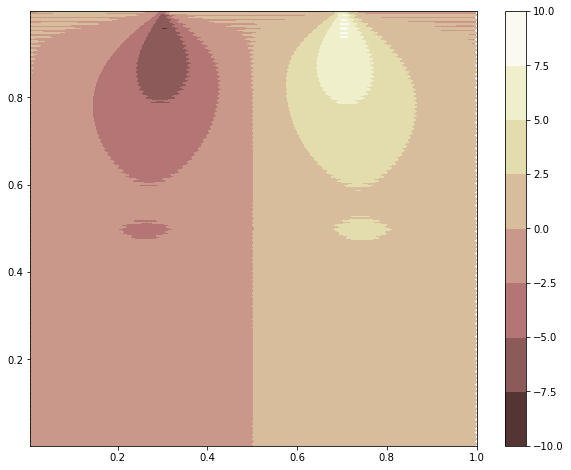

In [100]:
pointsx = solution[0][1][-2]
pointsy = solution[0][1][-1]
fig, ax = plt.subplots()
cs = ax.contourf(pointsx, pointsy, solution[0][0][9], cmap=cm.pink,)

cbar = fig.colorbar(cs)
fig.set_figwidth(10)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"
plt.show()


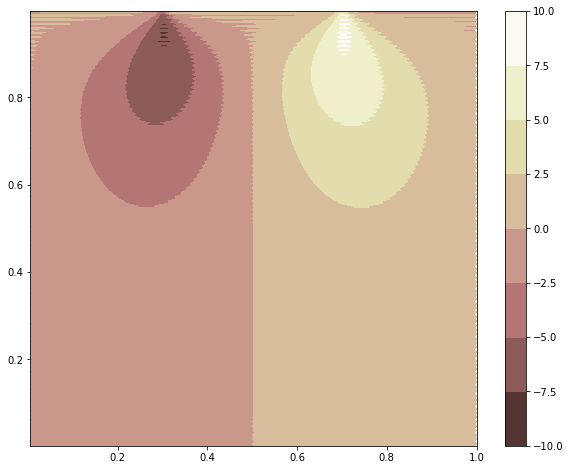

In [101]:
pointsx = solution[0][0][-2]
pointsy = solution[0][0][-1]
fig, ax = plt.subplots()
cs = ax.contourf(pointsx, pointsy, solution[0][1][9], cmap=cm.pink,)

cbar = fig.colorbar(cs)
fig.set_figwidth(10)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"
plt.show()


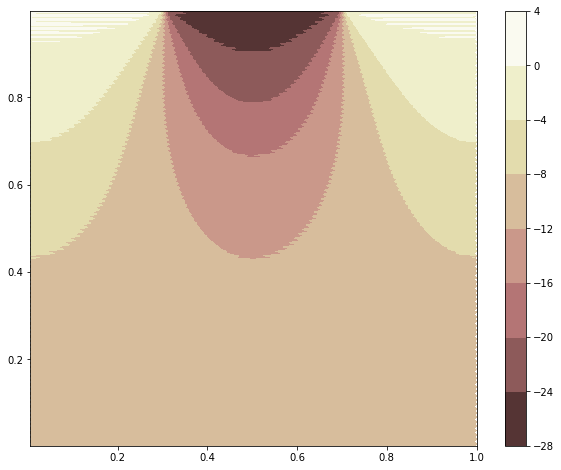

In [96]:
pointsx = solution[0][0][-2]
pointsy = solution[0][0][-1]
fig, ax = plt.subplots()
cs = ax.contourf(pointsx, pointsy, solution[0][1][8], cmap=cm.pink,)

cbar = fig.colorbar(cs)
fig.set_figwidth(10)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"
plt.show()


TypeError: Shape of x does not match that of z: found (101, 101) instead of (200, 100).

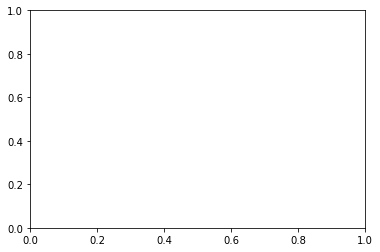

In [95]:
fig, ax = plt.subplots()
x_nodes = np.linspace(0, 1, Nx)
y_nodes = np.linspace(0, 1, Ny)
x_grid, y_grid = np.meshgrid(x_nodes, y_nodes)
cs = ax.contourf(x_grid, y_grid, solution[0][0][8], cmap=cm.pink)
cbar = fig.colorbar(cs)
fig.set_figwidth(10)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"
plt.show()

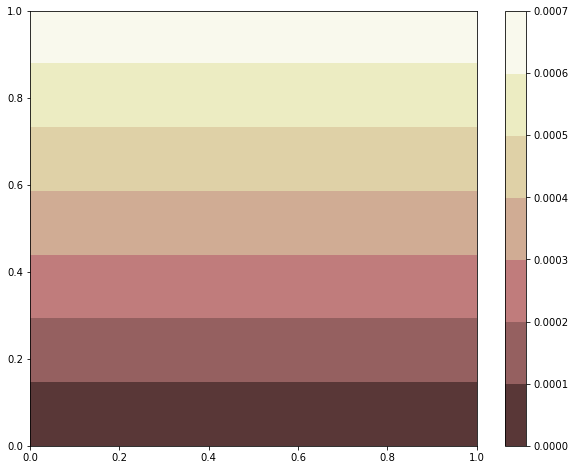

In [38]:
fig, ax = plt.subplots()
x_nodes = np.linspace(0, 1, Nx)
y_nodes = np.linspace(0, 1, Ny)
x_grid, y_grid = np.meshgrid(x_nodes, y_nodes)
cs = ax.contourf(x_grid, y_grid, solution[0][1][3], cmap=cm.pink)
cbar = fig.colorbar(cs)
fig.set_figwidth(10)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"
plt.show()

In [164]:
101*101

10201

In [238]:
sigy[50]

array([-1000.00070551, -1000.00082699, -1000.00083216, -1000.00051662,
       -1000.00046783, -1000.00015495,  -999.99975857,  -999.99968009,
        -999.99943489,  -999.99944446,  -999.99948861,  -999.99947047,
        -999.99958659,  -999.99945265,  -999.99961485,  -999.99941838,
        -999.99943977,  -999.99939029,  -999.99974056,  -999.99969947,
        -999.99989257, -1000.00007736, -1000.00017729, -1000.00021357,
       -1000.00006994, -1000.00049934, -1000.00026404, -1000.00043036,
       -1000.00021289, -1000.00005774, -1000.00025871, -1000.00025729,
       -1000.00008784, -1000.00030917, -1000.00037421, -1000.00013975,
       -1000.00021615, -1000.00005415, -1000.00007471, -1000.0002115 ])

In [206]:
h=0
err = 0
for i in uy:
    err += np.sum((i - -0.91/1.8/10*h)**2)
    h+=0.02

In [209]:
err = np.sqrt(err)/np.sum(uy**2)
err

0.00014789237414396993

In [137]:
f = 0,0
s = 1,1
Nx = 41
Ny = 41



In [158]:
len(x_grid[0])

101

In [159]:
0.91/1.8/10

0.050555555555555555

In [160]:
len(sigy)

200

In [59]:
f, u, ux, uy, ex, ey, exy, sigx, sigy, sigxy, pointsx, pointsy = solution[0][1]

In [84]:
np.sqrt(np.sum((sigx - -45)**2))/sigx.size

1.422687224738782e-06

In [85]:
np.sqrt(np.sum((sigy - -150)**2))/sigy.size

1.4023122227976208e-06

In [63]:
np.sqrt(np.sum((sigxy)**2))/sigxy.size

9.481689589973898e-07

In [73]:
np.sqrt(np.sum((ex)**2))/ex.size

7.761458152068216e-12

In [74]:
kl = (-150*0.91/2/10**5)

In [86]:
np.sqrt(np.sum((ey - -150*0.91/2/10**5)**2))/ey.size

7.676637089004243e-12

In [68]:
np.sqrt(np.sum((exy)**2))/exy.size

1.2326196466966068e-11

In [69]:
np.sqrt(np.sum((ux)**2))/ex.size

5.957316829108375e-13

In [83]:
err = 0
for i,u in enumerate(uy):
    err += np.sum((u - kl*i*0.01)**2)
print(np.sqrt(err)/np.sqrt(np.sum(uy**2)))

3.375630016203827e-07


In [210]:
sigy.size

20000

In [147]:
ey

array([[-0.05055551, -0.05055548, -0.05055548, ..., -0.05055558,
        -0.05055556, -0.05055556],
       [-0.05055548, -0.05055548, -0.05055551, ..., -0.05055556,
        -0.05055556, -0.05055557],
       [-0.05055546, -0.05055548, -0.05055554, ..., -0.05055555,
        -0.05055554, -0.05055552],
       ...,
       [-0.05055557, -0.05055555, -0.05055554, ..., -0.05055557,
        -0.05055562, -0.05055565],
       [-0.05055556, -0.05055553, -0.05055555, ..., -0.05055559,
        -0.0505556 , -0.05055565],
       [-0.05055553, -0.05055555, -0.0505555 , ..., -0.0505556 ,
        -0.05055565, -0.05055568]])

In [137]:
f = 0,0
s = 1,1
Nx = 41
Ny = 41



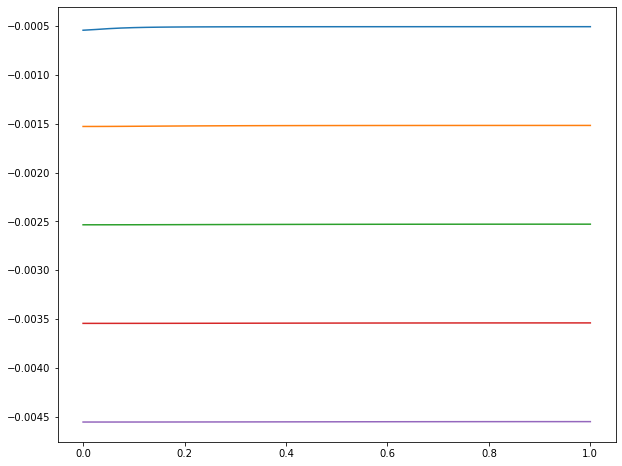

In [249]:
fig, ax = plt.subplots()
x_nodes = np.linspace(0, 1, Nx)
y_nodes = np.linspace(0, 1, Ny)
x_grid, y_grid = np.meshgrid(x_nodes, y_nodes)
for i in [0.1, 0.3, 0.5, 0.7, 0.9]:
    d = 0.025
    k = round(i/d)
    plt.plot(x_grid[k,:], uy[k,:])
fig.set_figwidth(10)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"
plt.show()